In [1]:
import xarray as xr
import datetime

In [2]:
# load data
dataset = xr.open_dataset('/home/joao/Downloads/ERA5_20160823.nc')

In [3]:
# print variables of file
print(dataset)

<xarray.Dataset>
Dimensions:    (latitude: 721, level: 19, longitude: 1440, time: 4)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 100 150 200 250 300 350 ... 800 850 900 950 1000
  * time       (time) datetime64[ns] 2016-08-23 ... 2016-08-23T18:00:00
Data variables:
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-08-11 03:21:07 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...


In [4]:
# gets fields
uwind = dataset['u']
vwind = dataset['v']
temp = dataset['t']

In [5]:
# define the region of interest
LonMin, LonMaj = 310.0, 340.0 # longitud
LatMin, LatMaj = -50.0, -10.0 # latitud
LevPres = 300 # pressure level
LevInf, LevSup = 350, 250
DateTime = datetime.datetime(2016,8,23,12,0) # DateTime

In [6]:
# select region of interest

# here the uwind, vwind and temperature are slice and they pass from 4D to 2D!
# note that in time and level were selected only one specific date-time and one specific presurre level
uwind2D = uwind.sel(time=DateTime, level=LevPres,
                  latitude=slice(LatMaj, LatMin), longitude=slice(LonMin, LonMaj))
vwind2D = vwind.sel(time=DateTime, level=LevPres,
                  latitude=slice(LatMaj, LatMin), longitude=slice(LonMin, LonMaj))
temp2D = temp.sel(time=DateTime, level=LevPres,
                latitude=slice(LatMaj, LatMin), longitude=slice(LonMin, LonMaj))

# check the shape of fields
print('Dimension of fields')
print('\tuwind2D: {}'.format(uwind2D.shape))
print('\tvwind2D: {}'.format(vwind2D.shape))
print('\ttemp2D: {}'.format(temp2D.shape))


# here temperature was slice as a layer but mainteining a 3D structure
# note that level was slice using the same pressure level value
# thus temperature field maintains pressure level informarion in their metadata
temp3D_layer = temp.sel(time=DateTime, level=slice(LevPres, LevPres),
                latitude=slice(LatMaj, LatMin), longitude=slice(LonMin, LonMaj))

# check the shape of field
print('\nDimension of 3D layer')
print('\ttemp3D_layer: {}'.format(temp3D_layer.shape))


# here the uwind and vwind are slice and they pass from 4D to 3D!
uwind3D = uwind.sel(time=DateTime, level=slice(LevSup, LevInf),
                  latitude=slice(LatMaj, LatMin), longitude=slice(LonMin, LonMaj))
vwind3D = vwind.sel(time=DateTime, level=slice(LevSup, LevInf),
                  latitude=slice(LatMaj, LatMin), longitude=slice(LonMin, LonMaj))
temp3D = temp.sel(time=DateTime, level=slice(LevSup, LevInf),
                latitude=slice(LatMaj, LatMin), longitude=slice(LonMin, LonMaj))

# check the shape of fields
print('\nDimension of 3D fields')
print('\tuwind2D: {}'.format(uwind3D.shape))
print('\tvwind2D: {}'.format(vwind3D.shape))
print('\ttemp3D:  {}'.format(temp3D.shape))

Dimension of fields
	uwind2D: (161, 121)
	vwind2D: (161, 121)
	temp2D: (161, 121)

Dimension of 3D layer
	temp3D_layer: (1, 161, 121)

Dimension of 3D fields
	uwind2D: (3, 161, 121)
	vwind2D: (3, 161, 121)
	temp3D:  (3, 161, 121)


In [7]:
# calculate vorticity and divergence

# import library
import metlib

# calculates relative vorticity
vor = metlib.relative_vorticity(uwind2D, vwind2D)*1.0e5

# calculates absolute vorticity
abs_vor = metlib.absolute_vorticity(uwind2D, vwind2D)*1.0e5

# calculates divergence
div = metlib.divergence(uwind2D, vwind2D)*1.0e5

# calculates temperature advection
temp_adv = metlib.advection(temp2D, uwind2D, vwind2D)*3600.0 # multiply by 3600.0 to pass K/s to K/h

# calculates potential temperature
pot_temp = metlib.potential_temperature(temp3D_layer)

# calculates potential vorticity
pot_vor3D = metlib.potential_vorticity(temp3D, uwind3D, vwind3D)*1.0e6

In [8]:

# Relative vorticity plot


In [9]:
# creates a custom color palette with custom_color_palette package
# see https://github.com/joaohenry23/custom_color_palette

import numpy as np
import matplotlib.pyplot as plt
import custom_color_palette as ccpl

mypalette, colorslabels, norm = ccpl.creates_palette([plt.cm.bwr],[-5.5,5.5])

# creating colorbar labels
tickslabels = np.arange(-5.5, 6.5, 1.0)

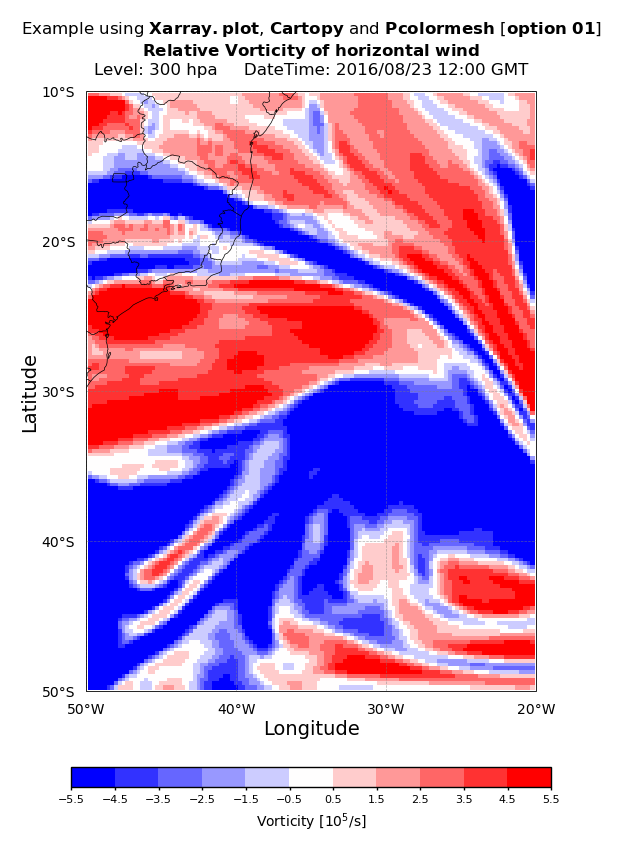

In [11]:
# PLOTTING VORTICITY OF HORIZONTAL WIND [OPTION 01: USING XARRAY.PLOT, CARTOPY AND PCOLORMESH]

# gets lons, lats, levs and times
Lons = vor['longitude'].values-360.0
Lats = vor['latitude'].values
levs = vor['level'].values
times = vor['time'].values.astype('datetime64[s]').tolist()

# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# defines map projection
MapProj = ccrs.PlateCarree()

# defines field projection
FieldProj = ccrs.PlateCarree()

# creates figure
fig = plt.figure('Vorticity Xarray.plot, Cartopy y Pcolormesh',figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75], projection=MapProj)

# add geographic boundaries
countries = cf.NaturalEarthFeature(category='cultural',
                                   name='admin_0_countries',
                                   scale='50m', facecolor='none')
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
states = cf.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='50m', facecolor='none')
ax.add_feature(states, edgecolor='black', linewidth=0.25)

# plot image
img = vor.plot.pcolormesh('longitude', 'latitude', cmap=mypalette, norm=norm, ax=ax,
                          extend='both', infer_intervals=True,
                          transform=FieldProj, add_colorbar = False)

# customizing the plot border
ax.outline_patch.set_linewidth(0.3)

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    spacing='proportional', orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.03, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Vorticity [$10^{5}$/s]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets X axis characteristics
xticks = np.arange(Lons.min(), Lons.max()+10.0,10.0)
ax.set_xticks(xticks, crs=MapProj)
ax.set_xticklabels(xticks, fontsize=5, color='black')
lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='°',
                                   dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlim(Lons.min(), Lons.max())


# sets Y axis characteristics
yticks = np.arange(Lats.min(), Lats.max()+10.0,10.0)
ax.set_yticks(yticks, crs=MapProj)
ax.set_yticklabels(yticks, fontsize=5, color='black')
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='°')
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylim(Lats.min(), Lats.max())


# sets grid characteristics
ax.tick_params(left=True, bottom=True, labelleft=True,
               labelbottom=True, length=0.0, width=0.05, pad=4.0)
ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', alpha=0.6,
             draw_labels=False, linewidth=0.25, linestyle='--')


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_title('{}\n{}\nLevel: {} hpa     DateTime: {}'
             .format(r'Example using $\bf{Xarray.plot}$, $\bf{Cartopy}$ and $\bf{Pcolormesh}$ [$\bf{option}$ $\bf{01}$]',
                     r'$\bf{Relative}$ $\bf{Vorticity}$ $\bf{of}$ $\bf{horizontal}$ $\bf{wind}$',
                     levs,
                     times.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

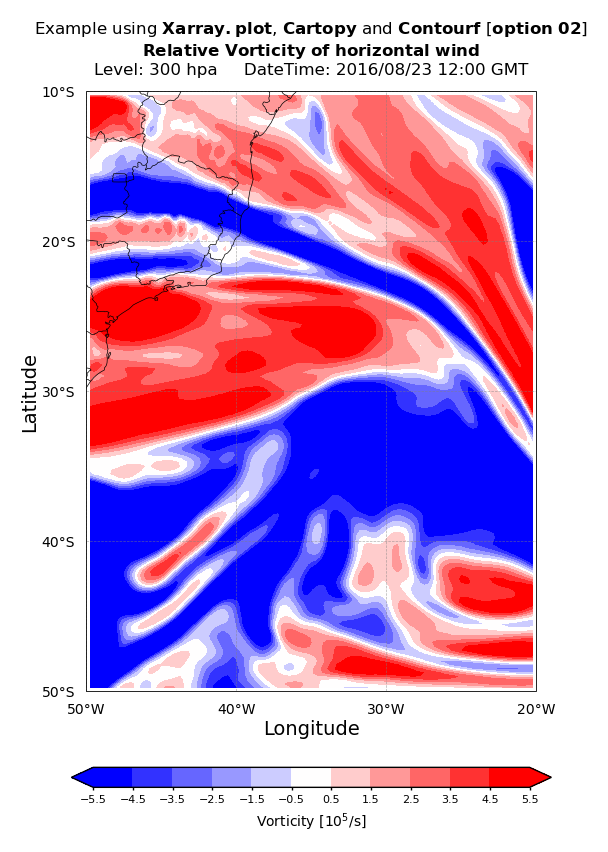

In [12]:
# PLOTTING VORTICITY OF HORIZONTAL WIND [OPTION 02: USING XARRAY.PLOT, CARTOPY AND CONTOURF]

# gets lons, lats, levs and times
Lons = vor['longitude'].values-360.0
Lats = vor['latitude'].values
levs = vor['level'].values
times = vor['time'].values.astype('datetime64[s]').tolist()

# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# defines map projection
MapProj = ccrs.PlateCarree()

# defines field projection
FieldProj = ccrs.PlateCarree()

# creates figure
fig = plt.figure('Vorticity Xarray.plot, Cartopy y Contourf',figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75], projection=MapProj)

# add geographic boundaries
countries = cf.NaturalEarthFeature(category='cultural',
                                   name='admin_0_countries',
                                   scale='50m', facecolor='none')
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
states = cf.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='50m', facecolor='none')
ax.add_feature(states, edgecolor='black', linewidth=0.25)

# plot image
img = vor.plot.contourf('longitude', 'latitude', cmap=mypalette,
                        levels=colorslabels, ax=ax,
                        extend='both', infer_intervals=True,
                        transform=FieldProj, add_colorbar = False)

# customizing the plot border
ax.outline_patch.set_linewidth(0.3)

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    #spacing='proportional',
                    orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.03, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Vorticity [$10^{5}$/s]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets X axis characteristics
xticks = np.arange(Lons.min(), Lons.max()+10.0,10.0)
ax.set_xticks(xticks, crs=MapProj)
ax.set_xticklabels(xticks, fontsize=5, color='black')
lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='°',
                                   dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlim(Lons.min(), Lons.max())


# sets Y axis characteristics
yticks = np.arange(Lats.min(), Lats.max()+10.0,10.0)
ax.set_yticks(yticks, crs=MapProj)
ax.set_yticklabels(yticks, fontsize=5, color='black')
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='°')
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylim(Lats.min(), Lats.max())


# sets grid characteristics
ax.tick_params(left=True, bottom=True, labelleft=True,
               labelbottom=True, length=0.0, width=0.05, pad=4.0)
ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', alpha=0.6,
             draw_labels=False, linewidth=0.25, linestyle='--')


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_title('{}\n{}\nLevel: {} hpa     DateTime: {}'
             .format(r'Example using $\bf{Xarray.plot}$, $\bf{Cartopy}$ and $\bf{Contourf}$ [$\bf{option}$ $\bf{02}$]',
                     r'$\bf{Relative}$ $\bf{Vorticity}$ $\bf{of}$ $\bf{horizontal}$ $\bf{wind}$',
                     levs,
                     times.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

In [13]:

# Absolute vorticity plot


In [14]:
# creates a custom color palette with custom_color_palette package
# see https://github.com/joaohenry23/custom_color_palette

import matplotlib.pyplot as plt
import custom_color_palette as ccpl

mypalette, colorslabels, norm = ccpl.creates_palette([plt.cm.RdYlBu_r],[0.0,20.0])

# creating colorbar labels
tickslabels = np.arange(0.0, 21.0, 5.0)

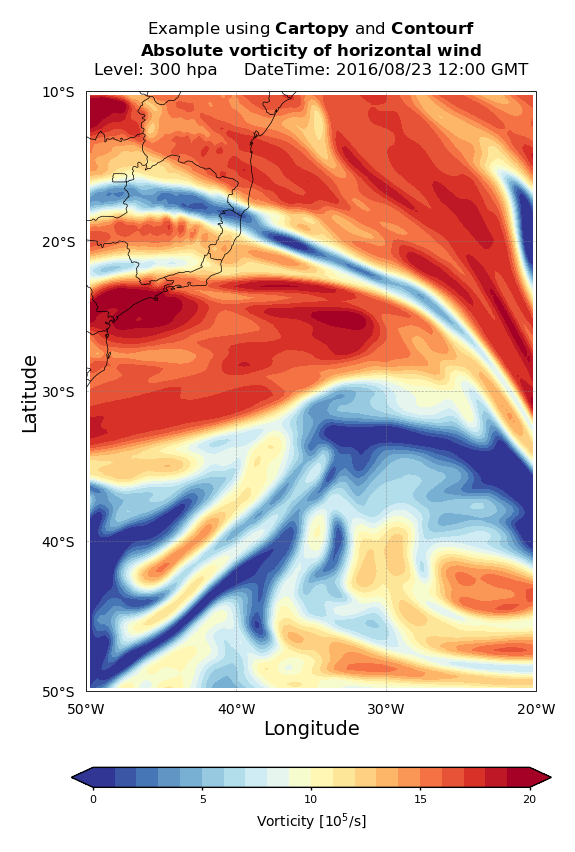

In [15]:
# PLOTTING ABSOLUTE VORTICITY [OPTION 02: USING XARRAY.PLOT, CARTOPY AND CONTOURF]

# gets lons, lats, levs and times
Lons = abs_vor['longitude'].values-360.0
Lats = abs_vor['latitude'].values
levs = abs_vor['level'].values
times = abs_vor['time'].values.astype('datetime64[s]').tolist()

# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# defines map projection
MapProj = ccrs.PlateCarree()

# defines field projection
FieldProj = ccrs.PlateCarree()

# creates figure
fig = plt.figure('Absolute vorticity Xarray.plot, Cartopy y Contourf',figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75], projection=MapProj)

# add geographic boundaries
countries = cf.NaturalEarthFeature(category='cultural',
                                   name='admin_0_countries',
                                   scale='50m', facecolor='none')
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
states = cf.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='50m', facecolor='none')
ax.add_feature(states, edgecolor='black', linewidth=0.25)

# plot image
img = abs_vor.plot.contourf('longitude', 'latitude', cmap=mypalette,
                        levels=colorslabels, ax=ax,
                        extend='both', infer_intervals=True,
                        transform=FieldProj, add_colorbar = False)

# customizing the plot border
ax.outline_patch.set_linewidth(0.3)

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    #spacing='proportional',
                    orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.03, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Vorticity [$10^{5}$/s]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets X axis characteristics
xticks = np.arange(Lons.min(), Lons.max()+10.0,10.0)
ax.set_xticks(xticks, crs=MapProj)
ax.set_xticklabels(xticks, fontsize=5, color='black')
lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='°',
                                   dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlim(Lons.min(), Lons.max())


# sets Y axis characteristics
yticks = np.arange(Lats.min(), Lats.max()+10.0,10.0)
ax.set_yticks(yticks, crs=MapProj)
ax.set_yticklabels(yticks, fontsize=5, color='black')
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='°')
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylim(Lats.min(), Lats.max())


# sets grid characteristics
ax.tick_params(left=True, bottom=True, labelleft=True,
               labelbottom=True, length=0.0, width=0.05, pad=4.0)
ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', alpha=0.6,
             draw_labels=False, linewidth=0.25, linestyle='--')


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_title('{}\n{}\nLevel: {} hpa     DateTime: {}'
             .format(r'Example using $\bf{Cartopy}$ and $\bf{Contourf}$',
                     r'$\bf{Absolute}$ $\bf{vorticity}$ $\bf{of}$ $\bf{horizontal}$ $\bf{wind}$',
                     levs,
                     times.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

In [16]:

# Divergence plot


In [17]:
# creates a custom color palette with custom_color_palette package
# see https://github.com/joaohenry23/custom_color_palette

import matplotlib.pyplot as plt
import custom_color_palette as ccpl

mypalette, colorslabels, norm = ccpl.creates_palette([plt.cm.RdBu_r],[-5.5,5.5],
                                                     EditPalette=[[-6.5,6.5,-5.5,5.5]])

# creating colorbar labels
tickslabels = np.arange(-5.5, 6.5, 1.0)

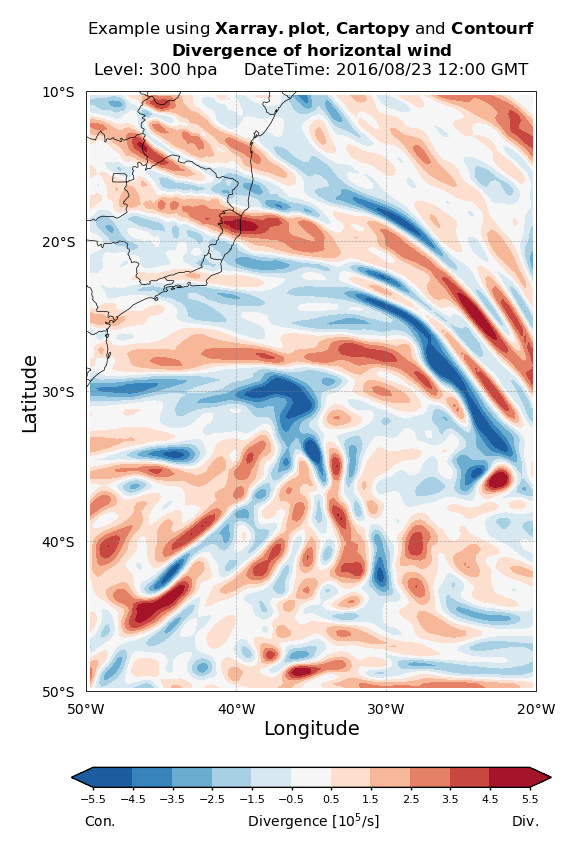

In [18]:
# PLOTTING DIVERGENCE OF HORIZONTAL WIND USING CARTOPY AND CONTOURF

# gets lons, lats, levs and times
Lons = div['longitude'].values-360.0
Lats = div['latitude'].values
levs = div['level'].values
times = div['time'].values.astype('datetime64[s]').tolist()

# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# defines map projection
MapProj = ccrs.PlateCarree()

# defines field projection
FieldProj = ccrs.PlateCarree()

# creates figure
fig = plt.figure('Divergence Xarray.plot, Cartopy y Contourf',figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75], projection=MapProj)

# add geographic boundaries
countries = cf.NaturalEarthFeature(category='cultural',
                                   name='admin_0_countries',
                                   scale='50m', facecolor='none')
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
states = cf.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='50m', facecolor='none')
ax.add_feature(states, edgecolor='black', linewidth=0.25)

# plot image
img = div.plot.contourf('longitude', 'latitude', cmap=mypalette,
                        levels=colorslabels, ax=ax,
                        extend='both', infer_intervals=True,
                        transform=FieldProj, add_colorbar = False)

# customizing the plot border
ax.outline_patch.set_linewidth(0.3)

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    #spacing='proportional',
                    orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.03, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label('Con.'+' '*30+r'Divergence [$10^{5}$/s]'+' '*30+'Div.', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets X axis characteristics
xticks = np.arange(Lons.min(), Lons.max()+10.0,10.0)
ax.set_xticks(xticks, crs=MapProj)
ax.set_xticklabels(xticks, fontsize=5, color='black')
lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='°',
                                   dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlim(Lons.min(), Lons.max())


# sets Y axis characteristics
yticks = np.arange(Lats.min(), Lats.max()+10.0,10.0)
ax.set_yticks(yticks, crs=MapProj)
ax.set_yticklabels(yticks, fontsize=5, color='black')
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='°')
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylim(Lats.min(), Lats.max())


# sets grid characteristics
ax.tick_params(left=True, bottom=True, labelleft=True,
               labelbottom=True, length=0.0, width=0.05, pad=4.0)
ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', alpha=0.6,
             draw_labels=False, linewidth=0.25, linestyle='--')


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_title('{}\n{}\nLevel: {} hpa     DateTime: {}'
             .format(r'Example using $\bf{Xarray.plot}$, $\bf{Cartopy}$ and $\bf{Contourf}$',
                     r'$\bf{Divergence}$ $\bf{of}$ $\bf{horizontal}$ $\bf{wind}$',
                     levs,
                     times.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

In [19]:

# Temperature advection plot


In [20]:
# creates a custom color palette with custom_color_palette package
# see https://github.com/joaohenry23/custom_color_palette

import matplotlib.pyplot as plt
import custom_color_palette as ccpl

mypalette, colorslabels, norm = ccpl.creates_palette([plt.cm.coolwarm],[-5.5,5.5])

# creating colorbar labels
tickslabels = np.arange(-5.5, 6.5, 1.0)

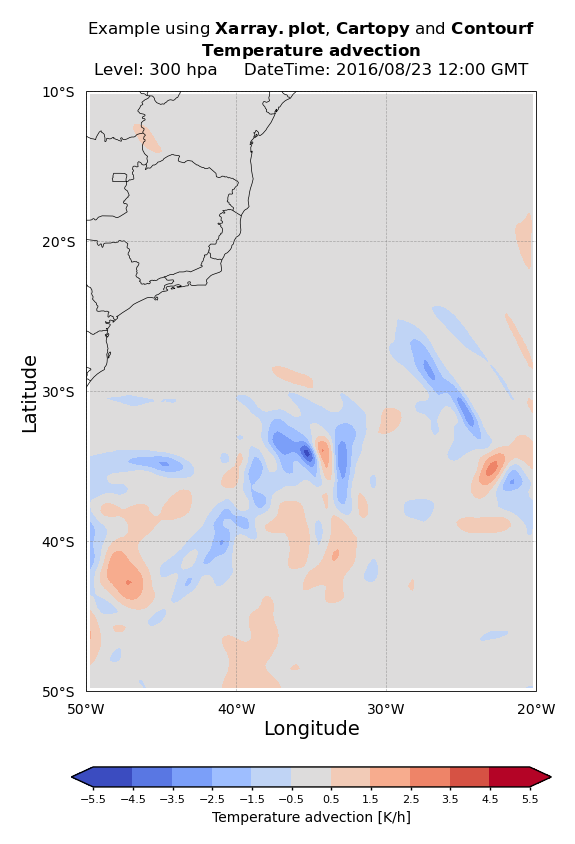

In [21]:
# PLOTTING TEMPERATURE ADVECTION USING CARTOPY AND CONTOURF

# gets lons, lats, levs and times
Lons = temp_adv['longitude'].values-360.0
Lats = temp_adv['latitude'].values
levs = temp_adv['level'].values
times = temp_adv['time'].values.astype('datetime64[s]').tolist()

# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# defines map projection
MapProj = ccrs.PlateCarree()

# defines field projection
FieldProj = ccrs.PlateCarree()

# creates figure
fig = plt.figure('Divergence Xarray.plot, Cartopy y Contourf',figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75], projection=MapProj)

# add geographic boundaries
countries = cf.NaturalEarthFeature(category='cultural',
                                   name='admin_0_countries',
                                   scale='50m', facecolor='none')
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
states = cf.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='50m', facecolor='none')
ax.add_feature(states, edgecolor='black', linewidth=0.25)

# plot image
img = temp_adv.plot.contourf('longitude', 'latitude', cmap=mypalette,
                             levels=colorslabels, ax=ax,
                             extend='both', infer_intervals=True,
                             transform=FieldProj, add_colorbar = False)

# customizing the plot border
ax.outline_patch.set_linewidth(0.3)

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    #spacing='proportional',
                    orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.03, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Temperature advection [K/h]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets X axis characteristics
xticks = np.arange(Lons.min(), Lons.max()+10.0,10.0)
ax.set_xticks(xticks, crs=MapProj)
ax.set_xticklabels(xticks, fontsize=5, color='black')
lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='°',
                                   dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlim(Lons.min(), Lons.max())


# sets Y axis characteristics
yticks = np.arange(Lats.min(), Lats.max()+10.0,10.0)
ax.set_yticks(yticks, crs=MapProj)
ax.set_yticklabels(yticks, fontsize=5, color='black')
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='°')
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylim(Lats.min(), Lats.max())


# sets grid characteristics
ax.tick_params(left=True, bottom=True, labelleft=True,
               labelbottom=True, length=0.0, width=0.05, pad=4.0)
ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', alpha=0.6,
             draw_labels=False, linewidth=0.25, linestyle='--')


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_title('{}\n{}\nLevel: {} hpa     DateTime: {}'
             .format(r'Example using $\bf{Xarray.plot}$, $\bf{Cartopy}$ and $\bf{Contourf}$',
                     r'$\bf{Temperature}$ $\bf{advection}$',
                     levs,
                     times.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

In [22]:

# Potential temperature plot


In [23]:
# creates a custom color palette with custom_color_palette package
# see https://github.com/joaohenry23/custom_color_palette

import matplotlib.pyplot as plt
import custom_color_palette as ccpl

mypalette, colorslabels, norm = ccpl.creates_palette([plt.cm.RdBu_r],[300, 350],Increase=[5.0])

# creating colorbar labels
tickslabels = np.arange(300.0, 355.0, 5.0)

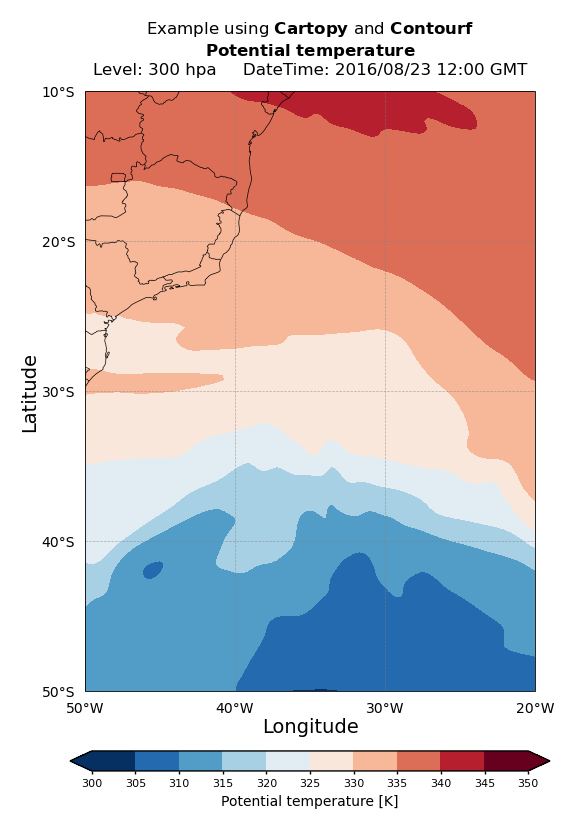

In [24]:
# PLOTTING POTENTIAL TEMPERATURE USING CARTOPY AND CONTOURF

# select level
pot_temp_2D = pot_temp.sel(level=LevPres)

# gets lons, lats, levs and times
Lons = pot_temp['longitude'].values-360.0
Lats = pot_temp['latitude'].values
levs = pot_temp_2D['level'].values
times = pot_temp_2D['time'].values.astype('datetime64[s]').tolist()

# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# defines map projection
MapProj = ccrs.PlateCarree()

# defines field projection
FieldProj = ccrs.PlateCarree()

# creates figure
fig = plt.figure('Temperature advection Cartopy Contourf', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75], projection=MapProj)
ax.set_extent(extents=[LonMin-360.0, LonMaj-360.0, LatMin, LatMaj],
              crs=MapProj)

# add geographic boundaries
countries = cf.NaturalEarthFeature(category='cultural',
                                   name='admin_0_countries',
                                   scale='50m', facecolor='none')
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
states = cf.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='50m', facecolor='none')
ax.add_feature(states, edgecolor='black', linewidth=0.25)

# plot image
img = pot_temp_2D.plot.contourf('longitude', 'latitude', cmap=mypalette,
                                levels=colorslabels, ax=ax,
                                extend='both', infer_intervals=True,
                                transform=FieldProj, add_colorbar = False)


# customizing the plot border
ax.outline_patch.set_linewidth(0.3)

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    #spacing='proportional',
                    orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.05, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Potential temperature [K]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets X axis characteristics
xticks = np.arange(Lons.min(), Lons.max()+10.0,10.0)
ax.set_xticks(xticks, crs=MapProj)
ax.set_xticklabels(xticks, fontsize=5, color='black')
lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='°',
                                   dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlim(Lons.min(), Lons.max())


# sets Y axis characteristics
yticks = np.arange(Lats.min(), Lats.max()+10.0,10.0)
ax.set_yticks(yticks, crs=MapProj)
ax.set_yticklabels(yticks, fontsize=5, color='black')
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='°')
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylim(Lats.min(), Lats.max())


# sets grid characteristics
ax.tick_params(left=True, bottom=True, labelleft=True,
               labelbottom=True, length=0.0, width=0.05)
ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', alpha=0.6,
             draw_labels=False, linewidth=0.25, linestyle='--')
ax.set_xlim(LonMin-360.0, LonMaj-360.0)
ax.set_ylim(LatMin, LatMaj)


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_title('{}\n{}\nLevel: {:.0f} hpa     DateTime: {}'
             .format(r'Example using $\bf{Cartopy}$ and $\bf{Contourf}$',
                     r'$\bf{Potential}$ $\bf{temperature}$',
                     levs,
                     times.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()

In [25]:

# Potential vorticity plot


In [26]:
# creates a custom color palette with custom_color_palette package
# see https://github.com/joaohenry23/custom_color_palette

import matplotlib.pyplot as plt
import custom_color_palette as ccpl

ColorList = ['navy','dodgerblue','lightskyblue','white','khaki','coral','crimson']
mypalette, colorslabels, norm = ccpl.creates_palette([ColorList],[-3.0, 3.0],
                                                     Increase=[0.2])

# creating colorbar labels
tickslabels = np.arange(-3.0, 4.0, 1.0)

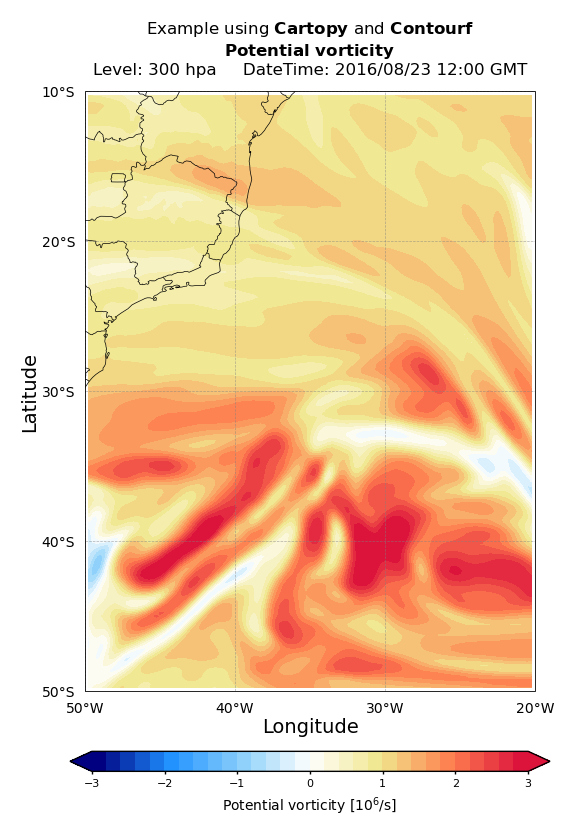

In [27]:
# PLOTTING POTENTIAL VORTICITY USING CARTOPY AND CONTOURF

# select level
pot_vor2D = pot_vor3D.sel(level=LevPres)

# gets lons, lats, levs and times
lons = pot_vor2D['longitude'].values-360.0
lats = pot_vor2D['latitude'].values
levs = pot_vor2D['level'].values
times = pot_vor2D['time'].values.astype('datetime64[s]').tolist()

# creates 2D array of lons and lats
lonsCen2D, latsCen2D = np.meshgrid(lons, lats)

# import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# defines map projection
MapProj = ccrs.PlateCarree()

# defines field projection
FieldProj = ccrs.PlateCarree()

# creates figure
fig = plt.figure('Temperature advection Cartopy Contourf', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.15, 0.80, 0.75], projection=MapProj)
ax.set_extent(extents=[LonMin-360.0, LonMaj-360.0, LatMin, LatMaj],
              crs=MapProj)

# add geographic boundaries
countries = cf.NaturalEarthFeature(category='cultural',
                                   name='admin_0_countries',
                                   scale='50m', facecolor='none')
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
states = cf.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='50m', facecolor='none')
ax.add_feature(states, edgecolor='black', linewidth=0.25)

# plot image
img = pot_vor2D.plot.contourf('longitude', 'latitude', cmap=mypalette,
                              levels=colorslabels, ax=ax,
                              extend='both', infer_intervals=True,
                              transform=FieldProj, add_colorbar = False)


# customizing the plot border
ax.outline_patch.set_linewidth(0.3)

# plot colorbar
cbar = plt.colorbar(img, ticks=tickslabels, extend='neither',
                    #spacing='proportional',
                    orientation='horizontal',
                    cax=fig.add_axes([0.20, 0.05, 0.60, 0.025]))
cbar.ax.tick_params(labelsize=4, labelcolor='black',
                    width=0.5, length=1.2, direction='out', pad=1.5)
cbar.set_label(r'Potential vorticity [$10^{6}$/s]', size=5, color='black',
               weight='normal', labelpad=2.0)
cbar.outline.set_linewidth(0.5)


# sets X axis characteristics
xticks = np.arange(Lons.min(), Lons.max()+10.0,10.0)
ax.set_xticks(xticks, crs=MapProj)
ax.set_xticklabels(xticks, fontsize=5, color='black')
lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='°',
                                   dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_xlim(Lons.min(), Lons.max())


# sets Y axis characteristics
yticks = np.arange(Lats.min(), Lats.max()+10.0,10.0)
ax.set_yticks(yticks, crs=MapProj)
ax.set_yticklabels(yticks, fontsize=5, color='black')
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='°')
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylim(Lats.min(), Lats.max())


# sets grid characteristics
ax.tick_params(left=True, bottom=True, labelleft=True,
               labelbottom=True, length=0.0, width=0.05)
ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', alpha=0.6,
             draw_labels=False, linewidth=0.25, linestyle='--')
ax.set_xlim(LonMin-360.0, LonMaj-360.0)
ax.set_ylim(LatMin, LatMaj)


# sets labels
ax.set_xlabel('Longitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_ylabel('Latitude', fontdict={'fontsize':7}, labelpad=1.0)
ax.set_title('{}\n{}\nLevel: {:.0f} hpa     DateTime: {}'
             .format(r'Example using $\bf{Cartopy}$ and $\bf{Contourf}$',
                     r'$\bf{Potential}$ $\bf{vorticity}$',
                     levs,
                     times.strftime('%Y/%m/%d %H:%M GMT')),
             fontdict={'fontsize':6}, pad=6.0)

plt.show()